In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
from scipy import integrate
from numpy import loadtxt

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams.update({'font.size': 11})

### Setting Parameters

In [2]:
h=0.675
Omb_fid=0.048
Omc_fid=0.268
ns_fid=0.965
As_fid=2e-09
w_fid=-1.0

z_min=0.5
z_max=0.55
f_sky=0.08
n_spec=1.5*(10**(-4.))
n_phot=1.5*(10**(-4.))

n_bar=3.*(10**(-4))

theta=np.linspace(0,np.pi, 101)
mu=np.cos(theta)
sig_z=0.005
z_bar=0.525

Omch2=np.array([(Omc_fid-0.005)*(h**2),Omc_fid*(h**2), (Omc_fid+0.005)*(h**2)])
W=np.array([w_fid-0.08, w_fid, w_fid+0.08])

Params= np.vstack((W, Omch2))

In [3]:
print 'w=',W
print 'Om_c=',Omch2/h**2.

w= [-1.08 -1.   -0.92]
Om_c= [ 0.263  0.268  0.273]


### Calculate matter power spectrum for various cosmologies

In [4]:
def Power_spectrum(params):
    PS=np.zeros((np.size(params,1), np.size(params,1), 200))
    H_bar=np.zeros((np.size(params,1), np.size(params,1)))

    for i in range(np.size(params,1)):
        for j in range(np.size(params,1)):
            if ((i+j)%2)!=0:
                print 'Calculating matter power spectrum','(%s,%s)'%(i, j), 'for parameters:','w=',params[0][i],'Om_cdm=',params[1][j]

                pars = camb.CAMBparams()
                pars.set_cosmology(H0=100.*h, ombh2=Omb_fid*(h**2), omch2=params[1][j], omk=0)
                pars.set_dark_energy(params[0][i])
                pars.InitPower.set_params(As= As_fid, ns=ns_fid)
                pars.set_matter_power(redshifts=[z_bar], kmax=2.0)

                pars.NonLinear = model.NonLinear_none
                results = camb.get_results(pars)
                kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
                PS[i][j]=pk
                                
                results2=camb.get_background(pars)
                H_bar[i][j] = results2.h_of_z(z_bar)

    return kh, PS, H_bar
k,power_spec,H_bar=Power_spectrum(Params)

Calculating matter power spectrum (0,1) for parameters: w= -1.08 Om_cdm= 0.1221075
Calculating matter power spectrum (1,0) for parameters: w= -1.0 Om_cdm= 0.119829375
Calculating matter power spectrum (1,2) for parameters: w= -1.0 Om_cdm= 0.124385625
Calculating matter power spectrum

 (2,1) for parameters: w= -0.92 Om_cdm= 0.1221075


### Fiducial case

In [5]:
pars_fid = camb.CAMBparams()
pars_fid.set_cosmology(H0=100.*h, ombh2=Omb_fid*(h**2), omch2=Params[1][1], omk=0)
pars_fid.set_dark_energy(Params[0][1])
pars_fid.InitPower.set_params(As= As_fid, ns=ns_fid)
pars_fid.set_matter_power(redshifts=[z_bar], kmax=2.0)

pars_fid.NonLinear = model.NonLinear_none
res_fid = camb.get_results(pars_fid)

_,_,power_spec[1][1]=res_fid.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
H_bar[1][1] = res_fid.h_of_z(z_bar)

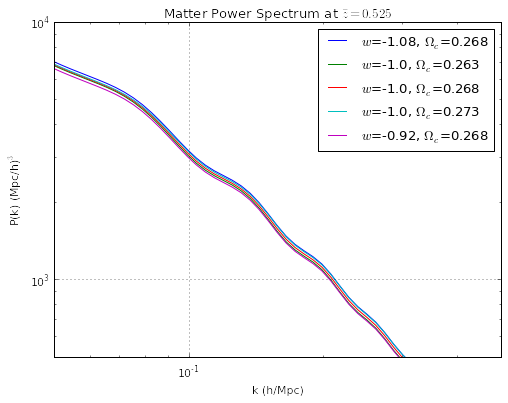

In [6]:
for i in range(len(power_spec)):
    for j in range(len(power_spec[i])):
        if power_spec[i][j][0]!=0:
            plt.loglog(k, power_spec[i][j], label=r'$w$=%s, $\Omega_c$=%s' %(Params[0][i], Params[1][j]/(h**2)))
plt.legend(loc='best')
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'P(k) (Mpc/h)$^3$')
plt.title(r'Matter Power Spectrum at $\bar{z} = 0.525$')
#plt.ylim(10**2, 5*10**4)
#plt.xlim(10**(-2), 1)
plt.ylim(5*10**2, 10**4)
plt.xlim(5*10**(-2), 0.5)
plt.grid()

In [7]:
c=299792.
print 'H(z_bar=%s) (km/s/Mpc) for each cosmology we will use:'%(z_bar)
print H_bar*c

H(z_bar=0.525) (km/s/Mpc) for each cosmology we will use:
[[  0.          89.11541535   0.        ]
 [ 90.46046697  90.78056036  91.09952906]
 [  0.          92.58828683   0.        ]]


### Calculating $P_{pp}$, $P_{sp}$ and $P_{ss}$

\begin{align}
P_{pp}(k, \mu) &= b^2_p |e^{-\frac{1}{2} k^2 \mu^2 \sigma^2_z/ H^2(\bar{z})}|^2 P(k) \\
P_{sp}(k,\mu) &= b_s b_p e^{-\frac{1}{2} k^2 \mu^2 \sigma^2_z/ H^2(\bar{z})} P(k) \\
P_{ss}(k) &= b^2_s P(k)
\end{align}

For the moment the biases $b_s$ and $b_p$ are set equal to 1.

In [8]:
PS_pp=np.zeros((np.size(Params,1), np.size(Params,1), len(mu), 200))
PS_sp=np.zeros((np.size(Params,1), np.size(Params,1), len(mu), 200))
PS_ss=np.zeros((np.size(Params,1), np.size(Params,1), len(mu), 200))

for i in range(np.size(Params,1)):
    for j in range(np.size(Params,1)):
        if ((i+j)%2)!=0 or (i==1 and j==1):
            for l in range(len(mu)):
                for m in range(len(k)):
                    PS_pp[i][j][l][m]=(abs(np.exp(-(((k[m])**2.)*((mu[l])**2.)*((sig_z)**2.))/(2.*((H_bar[i][j])**2.))))**2.)*power_spec[i][j][m]
                    PS_sp[i][j][l][m]=(np.exp(-(((k[m])**2.)*((mu[l])**2.)*((sig_z)**2.))/(2.*((H_bar[i][j])**2.))))*power_spec[i][j][m]
                    PS_ss[i][j][l][m]=power_spec[i][j][m]

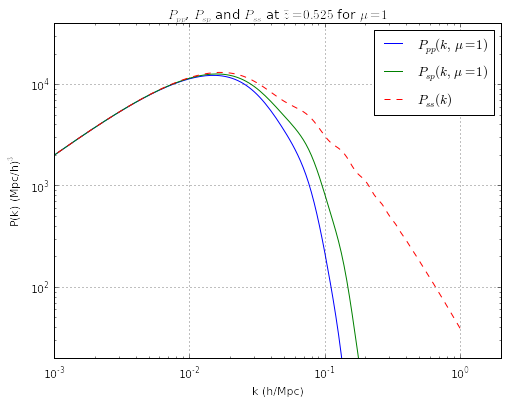

In [9]:
plt.loglog(k, PS_pp[1][1][0][:], label=r'$P_{pp}(k,\ \mu = 1)$')
plt.loglog(k, PS_sp[1][1][0][:], label=r'$P_{sp}(k,\ \mu = 1)$')
plt.loglog(k, PS_ss[1][1][0][:],'--', label=r'$P_{ss}(k)$')
plt.xlim(0.001, 2)
plt.ylim(2*10, 4*10**4)
plt.legend(loc='best')
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'P(k) (Mpc/h)$^3$')
plt.title(r'$P_{pp}$, $P_{sp}$ and $P_{ss}$ at $\bar{z} = 0.525$ for $\mu = 1$')
plt.grid()

### Derivatives

We will now take the derivative of the power spectra with respect to de parameters using central finite differences, i.e.

\begin{equation}
\frac{\partial P_{xy}}{\partial p} = \frac{P_{xy} (p=p_{fid}+\Delta p) - P_{xy} (p=p_{fid}-\Delta p)}{2\Delta p}
\end{equation}

In [10]:
dSS_i=(PS_ss[2][1]-PS_ss[0][1])/(Params[0][2]-Params[0][0])
dSS_j=(PS_ss[1][2]-PS_ss[1][0])/(Params[1][2]-Params[1][0])

dPP_i=(PS_pp[2][1]-PS_pp[0][1])/(Params[0][2]-Params[0][0])
dPP_j=(PS_pp[1][2]-PS_pp[1][0])/(Params[1][2]-Params[1][0])

dSP_i=(PS_sp[2][1]-PS_sp[0][1])/(Params[0][2]-Params[0][0])
dSP_j=(PS_sp[1][2]-PS_sp[1][0])/(Params[1][2]-Params[1][0])

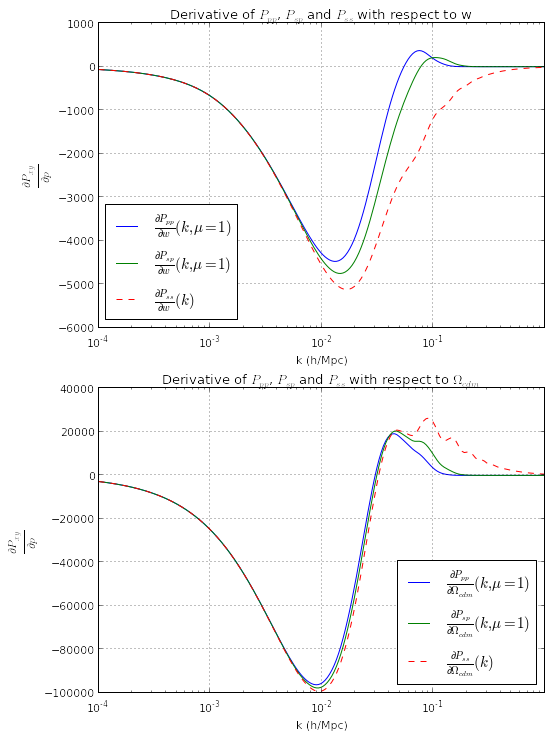

In [11]:
plt.rcParams['figure.figsize'] = (8, 12)

plt.subplot(2,1,1)
plt.plot(k, dPP_i[0,:], label=r'$\frac{\partial P_{pp}}{\partial w} (k, \mu=1)$')
plt.plot(k, dSP_i[0,:], label=r'$\frac{\partial P_{sp}}{\partial w} (k, \mu=1)$')
plt.plot(k, dSS_i[0, :],'--', label=r'$\frac{\partial P_{ss}}{\partial w} (k)$')
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\frac{\partial P_{xy}}{\partial p}$', fontsize=17)
plt.title(r'Derivative of $P_{pp}$, $P_{sp}$ and $P_{ss}$ with respect to w')
plt.xscale('log')
plt.legend(loc='best', prop={'size':15})
plt.grid()

plt.subplot(2,1,2)
plt.plot(k, dPP_j[0,:], label=r'$\frac{\partial P_{pp}}{\partial \Omega_{cdm}} (k, \mu=1)$')
plt.plot(k, dSP_j[0,:], label=r'$\frac{\partial P_{sp}}{\partial \Omega_{cdm}} (k, \mu=1)$')
plt.plot(k, dSS_j[0,:],'--', label=r'$\frac{\partial P_{ss}}{\partial \Omega_{cdm}} (k)$')
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\frac{\partial P_{xy}}{\partial p}$', fontsize=17)
plt.title(r'Derivative of $P_{pp}$, $P_{sp}$ and $P_{ss}$ with respect to $\Omega_{cdm}$')
plt.legend(loc='best', prop={'size':15})
plt.xscale('log')
plt.grid()

# Spectroscopic Fisher Matrix

\begin{equation}
F_{lm} = V_{\text{survey}} \int \frac{d^3 k}{(2\pi)^3} \frac{\partial P(k_i)}{\partial p_l} \frac{\partial P(k_i)}{\partial p_m} \left( \frac{1}{P(k_i) + \frac{1}{\bar{n}}} \right)^2
\end{equation}

Where the survey volume is given by

\begin{equation}
V_{survey} = \Omega \int^{z_{max}}_{z_{min}} \frac{r^2(z)}{H(z)} dz = 4\pi f_{sky} \int^{z_{max}}_{z_{min}} \frac{r^2(z)}{H(z)} dz
\end{equation}

In [12]:
def V_survey(Z_min, Z_max, F_sky):
    return 4.*np.pi*F_sky*(integrate.quad(lambda x: 
            ((res_fid.comoving_radial_distance(x))**2.)/(res_fid.h_of_z(x)), Z_min, Z_max)[0])

In [13]:
F_spec=np.zeros((len(Params),len(Params)))
dSS_ij= np.vstack((dSS_i[0], dSS_j[0]))
vs=V_survey(z_min,z_max, f_sky)

for i in range(len(Params)):
    for j in range(len(Params)):
        int_ij=(k**2.)*dSS_ij[i]*dSS_ij[j]*(1./((power_spec[1][1]+(1./n_bar))**2.))*(1./(4.*(np.pi)**2.))*vs
        F_spec[i][j]=integrate.simps(int_ij,k)

In [14]:
print 'Survey volume = ', vs/(1.e09), 'Gpc^3'

Survey volume =  0.683988016985 Gpc^3


In [15]:
print 'Spectroscopic Fisher Matrix:'
print F_spec

Spectroscopic Fisher Matrix:
[[    2374.88683075   -63064.94951909]
 [  -63064.94951909  1830355.67839652]]


In [16]:
#inverting and taking the square root:
print np.sqrt(np.linalg.inv(F_spec))

[[ 0.07036281  0.01306079]
 [ 0.01306079  0.00253453]]


# Spectroscopic and Photometric Fisher Matrix

\begin{equation}
F_{lm} = V\int \frac{d^3 k}{2(2\pi)^3} Tr\left[ \frac{\partial C}{\partial p_l} C^{-1} \frac{\partial C}{\partial p_m} C^{-1} \right],
\end{equation}

\begin{equation}
\left( \begin{array}{cccc}
P_{pp}+\frac{1}{\bar{n}_p} & P_{sp} \\
P_{sp} & P_{ss}+\frac{1}{\bar{n}_s} \\ \end{array} \right)
\end{equation}

### Calculating the covariance matrix and trace

In [17]:
trace_M=np.zeros((len(Params), len(Params),len(mu), 200))

for l in range(len(mu)):
    for m in range(len(k)):
        C=np.zeros((len(Params),len(Params)))
        dC_i=np.zeros((len(Params),len(Params)))
        dC_j=np.zeros((len(Params),len(Params)))
        C_inv=np.zeros((len(Params),len(Params)))

        C[0][0]=PS_pp[1][1][l][m]+(1./n_phot)
        C[0][1]=PS_sp[1][1][l][m]
        C[1][0]=PS_sp[1][1][l][m]
        C[1][1]=PS_ss[1][1][l][m]+(1./n_spec)
        
        dC_i[0][0]=dPP_i[l][m]
        dC_i[0][1]=dSP_i[l][m]
        dC_i[1][0]=dSP_i[l][m]
        dC_i[1][1]=dSS_i[l][m]
        
        dC_j[0][0]=dPP_j[l][m]
        dC_j[0][1]=dSP_j[l][m]
        dC_j[1][0]=dSP_j[l][m]
        dC_j[1][1]=dSS_j[l][m]
        
        C_inv=np.linalg.inv(C)

        trace_M[0][0][l][m]=((k[m])**2.)*(np.sin(theta[l]))*np.trace(np.dot(dC_i,np.dot(C_inv,np.dot(dC_i,C_inv))))
        trace_M[0][1][l][m]=((k[m])**2.)*(np.sin(theta[l]))*np.trace(np.dot(dC_i,np.dot(C_inv,np.dot(dC_j,C_inv))))
        trace_M[1][0][l][m]=((k[m])**2.)*(np.sin(theta[l]))*np.trace(np.dot(dC_j,np.dot(C_inv,np.dot(dC_i,C_inv))))
        trace_M[1][1][l][m]=((k[m])**2.)*(np.sin(theta[l]))*np.trace(np.dot(dC_j,np.dot(C_inv,np.dot(dC_j,C_inv))))

### Integrating to get $F_{lm}$

In [18]:
integ=np.zeros((len(Params), len(Params), len(mu)))

for l in range(len(mu)):
    integ[0][0][l]=integrate.simps(trace_M[0][0][l], k)
    integ[0][1][l]=integrate.simps(trace_M[0][1][l], k)
    integ[1][0][l]=integrate.simps(trace_M[1][0][l], k)
    integ[1][1][l]=integrate.simps(trace_M[1][1][l], k)
    
F=np.zeros((len(Params), len(Params)))
F=((integrate.simps(integ, theta))*vs)/(8.*np.pi**2.)

In [19]:
print 'Photometric + Spectroscopic Fisher Matrix:'
print F

Photometric + Spectroscopic Fisher Matrix:
[[   1049.54123465  -24926.04264642]
 [ -24926.04264642  822562.96467353]]


In [20]:
#inverting and taking the square root:
print np.sqrt(np.linalg.inv(F))

[[ 0.05830038  0.01014877]
 [ 0.01014877  0.00208251]]


# Problem (!)

With a separate file I ran this code for various values of $\sigma_z$. In principle, the variances of the model parameters should increase with $\sigma_z$ and should be equal to the single component Fisher matrix when $\sigma_z$ is very small (given my choices of $n_{spec} and n_{phot}$).

In fact they do coincide for very small $\sigma_z$, but it appears that they decrease in a certain interval of $\sigma_z$ and only latter begin to increase, as shown in the plots below.

In [21]:
Sig_w = loadtxt("sigma_w.txt", comments="#", delimiter=",", unpack=False)
Sig_cdm = loadtxt("sigma_cdm.txt", comments="#", delimiter=",", unpack=False)

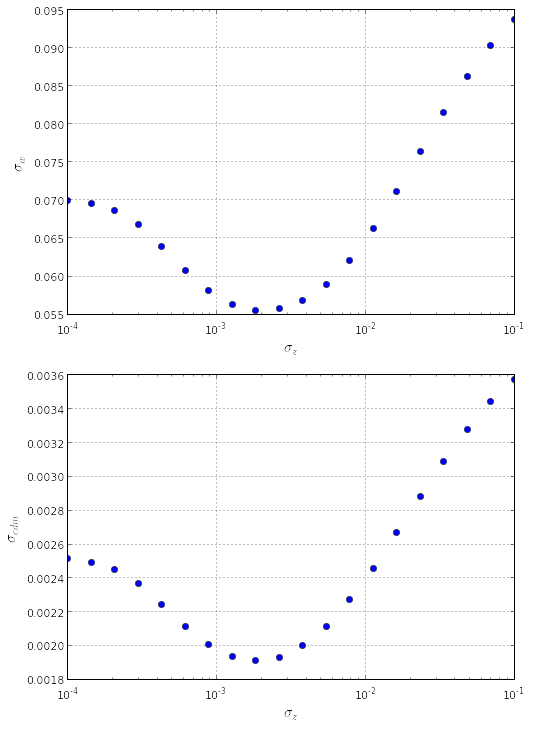

In [22]:
plt.rcParams['figure.figsize'] = (8, 12)

Sig_z=np.logspace(-4,-1, 20)

plt.subplot(2,1,1)
plt.plot(Sig_z, Sig_w, 'o')
plt.xscale('log')
plt.xlabel(r'$\sigma_z$', fontsize=15)
plt.ylabel(r'$\sigma_w$', fontsize=15)
plt.grid()

plt.subplot(2,1,2)
plt.plot(Sig_z, Sig_cdm, 'o')
plt.xscale('log')
plt.xlabel(r'$\sigma_z$', fontsize=15)
plt.ylabel(r'$\sigma_{cdm}$', fontsize=15)
plt.grid()